In [ ]:
# Run once in Colab
!pip install -q ultralytics transformers torch Pillow opencv-python-headless matplotlib scipy timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
import os, sys, math, warnings, io
import numpy as np, cv2, torch
import matplotlib.pyplot as plt
from PIL import Image, ExifTags
from google.colab import files
from ultralytics import YOLO
from scipy.spatial.distance import euclidean
from scipy.optimize import least_squares


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

def imshow_rgb(img_rgb, title=None, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def pil_to_bgr(pil_img):
    return cv2.cvtColor(np.array(pil_img.convert('RGB')), cv2.COLOR_RGB2BGR)

def save_debug(img, path):
    cv2.imwrite(path, img)

def exif_focal_px(pil_img, image_width_px, sensor_width_mm=None):
    # tries to get EXIF FocalLength (mm); convert to px if sensor_width provided
    try:
        exif = pil_img._getexif()
        if not exif: return None
        exif_map = {ExifTags.TAGS.get(k,k): v for k,v in exif.items()}
        if 'FocalLength' in exif_map:
            focal = exif_map['FocalLength']
            if isinstance(focal, tuple): focal = focal[0]/focal[1]
            if sensor_width_mm:
                fx = (focal / sensor_width_mm) * image_width_px
                return fx
            else:
                return focal
    except Exception:
        return None

In [ ]:
# -------------------------- Device --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [ ]:

print("Step A: Upload flange image (fronto-parallel recommended).")
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
else:
    # fallback if file exists in /mnt/data
    fallback = "/mnt/data/WhatsApp Image 2025-10-15 at 17.26.08_b39f6928.jpg"
    if os.path.exists(fallback):
        image_path = fallback
        print("Using fallback image:", image_path)
    else:
        raise SystemExit("No image uploaded. Upload an image and re-run.")

pil_image = Image.open(image_path).convert("RGB")
W, H = pil_image.size
print(f"Loaded: {image_path}  size: {W}x{H}")

Step A: Upload flange image (fronto-parallel recommended).


Saving WhatsApp Image 2025-09-13 at 22.40.39_8d5b0e4f.jpg to WhatsApp Image 2025-09-13 at 22.40.39_8d5b0e4f.jpg
Loaded: WhatsApp Image 2025-09-13 at 22.40.39_8d5b0e4f.jpg  size: 960x1280


In [ ]:

print("\nStep B: Upload YOLO .pt (your trained model). If none uploaded, using yolov8s demo (no custom classes).")
uploaded_m = files.upload()
if uploaded_m:
    yolo_path = list(uploaded_m.keys())[0]
    print("Using uploaded YOLO model:", yolo_path)
    yolo_model = YOLO(yolo_path)
else:
    print("No YOLO uploaded — using yolov8s default (demo only).")
    yolo_model = YOLO("yolov8s.pt")

yolo_model.to(device)


Step B: Upload YOLO .pt (your trained model). If none uploaded, using yolov8s demo (no custom classes).


Saving flange.pt to flange.pt
Using uploaded YOLO model: flange.pt


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [ ]:
import torch
import warnings
from transformers import DepthProForDepthEstimation, DepthProImageProcessorFast, AutoImageProcessor, AutoModelForDepthEstimation


In [ ]:
# -------------------------- Load depth model (DepthPro preferred, MiDaS fallback) --------------------------
print("\nStep C: Load depth model (DepthPro preferred). This may take time/downloading.")
image_processor = None
depth_model = None
use_depthpro = False
use_midas = False

try:
    from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
    dp_name = "apple/DepthPro-hf"
    image_processor = DepthProImageProcessorFast.from_pretrained(dp_name)
    depth_model = DepthProForDepthEstimation.from_pretrained(dp_name).to(device)
    use_depthpro = True
    print("Loaded DepthPro.")
except Exception as e:
    warnings.warn(f"DepthPro load failed: {e}\nFalling back to MiDaS.")
    try:
        use_midas = True
        midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        midas.to(device).eval()
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        transform = midas_transforms.small_transform
        depth_model = midas
        print("Loaded MiDaS (fallback).")
    except Exception as e2:
        raise SystemExit(f"Failed to load any depth model: {e2}")


Step C: Load depth model (DepthPro preferred). This may take time/downloading.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

Loaded DepthPro.



Step D: Run YOLO detection on full image.

0: 640x480 4 bolt_dias, 1 inner_dia, 1 outer_dia, 102.1ms
Speed: 30.0ms preprocess, 102.1ms inference, 41.0ms postprocess per image at shape (1, 3, 640, 480)
Detected boxes: 6
 0: outer_dia conf=0.97 bbox=[     61.469      357.12      914.77      1198.7]
 1: inner_dia conf=0.93 bbox=[     309.79      606.06      658.23      952.78]
 2: bolt_dia conf=0.90 bbox=[     116.39      634.27      204.91      725.68]
 3: bolt_dia conf=0.90 bbox=[     346.39      1058.9      438.94      1150.2]
 4: bolt_dia conf=0.90 bbox=[     534.97      405.71      623.09      496.09]
 5: bolt_dia conf=0.89 bbox=[     766.48      820.56      858.43      915.75]
Crop coords: (33, 329, 942, 1226)


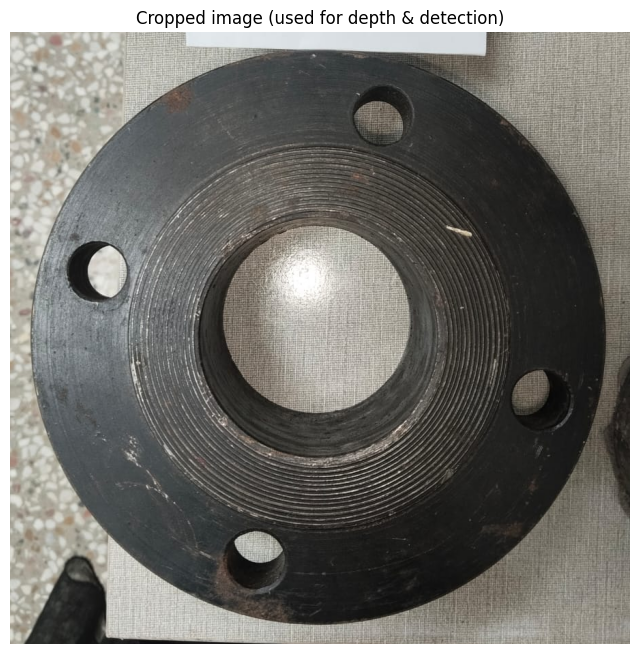

In [ ]:
# -------------------------- Run YOLO on full image --------------------------
print("\nStep D: Run YOLO detection on full image.")
results = yolo_model(pil_image, conf=0.35, iou=0.45)
res0 = results[0]
try:
    xyxy = res0.boxes.xyxy.cpu().numpy()
    cls_ids = res0.boxes.cls.cpu().numpy().astype(int)
    confidences = res0.boxes.conf.cpu().numpy()
    names = res0.names
except Exception:
    # fallback for different ultralytics versions
    xyxy = np.array([b.xyxy[0].tolist() for b in res0.boxes])
    cls_ids = np.array([int(b.cls[0]) for b in res0.boxes])
    confidences = np.array([float(b.conf[0]) for b in res0.boxes])
    names = res0.names if hasattr(res0, 'names') else {}

print("Detected boxes:", len(xyxy))
for i,(b,c,s) in enumerate(zip(xyxy, cls_ids, confidences)):
    lbl = names[int(c)] if isinstance(names, (list,dict)) else str(c)
    print(f" {i}: {lbl} conf={s:.2f} bbox={b}")

# Choose outer bbox: prefer class 'outer_dia' or largest area
outer_box = None
if len(xyxy) > 0:
    # try find 'outer' label
    for b,c in zip(xyxy, cls_ids):
        lbl = names[int(c)] if isinstance(names, (list,dict)) else str(c)
        if str(lbl).lower() in ['outer_dia','outer','od','outer_diameter']:
            outer_box = b; break
    if outer_box is None:
        areas = (xyxy[:,2]-xyxy[:,0])*(xyxy[:,3]-xyxy[:,1])
        idx = int(np.argmax(areas))
        outer_box = xyxy[idx]
else:
    outer_box = None

if outer_box is None:
    x1,y1,x2,y2 = 0,0,W,H
    print("No detection -> using full image.")
else:
    x1,y1,x2,y2 = map(int, outer_box)
    margin = int(min(W,H)*0.03)
    x1,y1 = max(0,x1-margin), max(0,y1-margin)
    x2,y2 = min(W,x2+margin), min(H,y2+margin)
print("Crop coords:", (x1,y1,x2,y2))

cropped = pil_image.crop((x1,y1,x2,y2))
crop_w, crop_h = cropped.size
cropped_bgr = pil_to_bgr(cropped)
imshow_rgb(bgr_to_rgb(cropped_bgr), title="Cropped image (used for depth & detection)")




Step E: Depth estimation on the crop.
DepthPro output shape: (897, 909)  focal_raw: tensor(1204.1708, device='cuda:0')


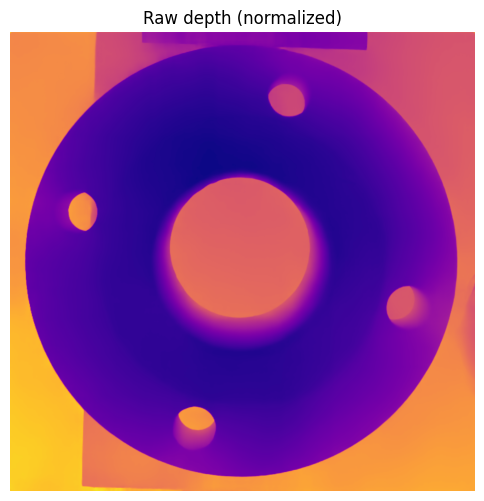

In [ ]:
# -------------------------- Depth estimation on crop --------------------------
print("\nStep E: Depth estimation on the crop.")
if use_depthpro:
    inputs = image_processor(images=cropped, return_tensors="pt").to(device)
    with torch.no_grad():
        outs = depth_model(**inputs)
    post = image_processor.post_process_depth_estimation(outs, target_sizes=[(crop_h, crop_w)])
    post0 = post[0]
    predicted_depth = post0.get("predicted_depth", None)
    focal_raw = post0.get("focal_length", None)
    if predicted_depth is None:
        raise RuntimeError("DepthPro returned no predicted_depth.")
    pred_np = predicted_depth.detach().cpu().squeeze().numpy().astype(np.float32)
    try:
        focal_px = float(focal_raw) if focal_raw is not None else None
    except:
        focal_px = None
    print("DepthPro output shape:", pred_np.shape, " focal_raw:", focal_raw)
else:
    # MiDaS fallback
    input_batch = transform(cropped).to(device)
    with torch.no_grad():
        prediction = depth_model(input_batch)
    pred_np = torch.nn.functional.interpolate(prediction.unsqueeze(1), size=(crop_h, crop_w), mode="bicubic", align_corners=False).squeeze().cpu().numpy().astype(np.float32)
    focal_px = None
    print("MiDaS pred shape:", pred_np.shape)

# visualize raw depth normalized
norm = (pred_np - pred_np.min()) / (pred_np.max() - pred_np.min() + 1e-9)
plt.figure(figsize=(6,6)); plt.imshow(norm, cmap='plasma'); plt.title("Raw depth (normalized)"); plt.axis('off'); plt.show()



In [ ]:
# -------------------------- Depth postprocess & representative depth --------------------------
print("\nStep F: Depth postprocessing")
pred_smooth = cv2.bilateralFilter(pred_np, d=9, sigmaColor=75, sigmaSpace=75)
dmedian = float(np.median(pred_smooth)); dstd = float(pred_smooth.std())
lower, upper = dmedian - 2*dstd, dmedian + 2*dstd
pred_clipped = np.clip(pred_smooth, lower, upper)
uniform_depth = float(np.median(pred_clipped))
print(f"Depth stats: median={dmedian:.4f}, std={dstd:.4f}, chosen uniform_depth={uniform_depth:.6f}")



Step F: Depth postprocessing
Depth stats: median=0.7111, std=0.0919, chosen uniform_depth=0.711149


In [ ]:
# Determine focal px if missing: try EXIF -> heuristic fallback
if focal_px is None:
    exif_val = exif_focal_px(pil_image, image_width_px=W, sensor_width_mm=None)
    if exif_val is not None:
        print("EXIF focal found (mm or px):", exif_val, "(sensor width unknown -> can't convert to px automatically)")
        focal_px_est = 0.5 * W
        print(f"Using heuristic focal px = {focal_px_est:.1f} px for diagnostics")
        focal_px = focal_px_est
    else:
        focal_px = 0.5 * W
        print(f"No focal info; using heuristic focal px = {focal_px:.1f} px (coarse)")


In [ ]:
# -------------------------- Detection of bolt holes & circles --------------------------
print("\nStep G: Detect bolt holes & circles (YOLO + Hough & contour fallback).")
# Adjust YOLO boxes to crop coords
boxes = xyxy.copy() if len(xyxy)>0 else np.empty((0,4))
cls_ids = cls_ids if len(xyxy)>0 else np.array([])
names_map = names

bolt_centers = []
bolt_radii_px = []
outer_px_diameter = None
inner_px_diameter = None
outer_center = None

for b, cid in zip(boxes, cls_ids):
    bx1,by1,bx2,by2 = map(int, b)
    ax1 = bx1 - x1; ay1 = by1 - y1; ax2 = bx2 - x1; ay2 = by2 - y1
    ax1,ay1 = max(0,ax1), max(0,ay1)
    ax2,ay2 = min(crop_w-1, ax2), min(crop_h-1, ay2)
    w,h = ax2-ax1, ay2-ay1
    if w<=0 or h<=0: continue
    lbl = names_map[int(cid)] if isinstance(names_map,(list,dict)) else str(cid)
    lc = str(lbl).lower()
    cx = int(ax1 + w/2); cy = int(ay1 + h/2)
    if 'bolt' in lc or 'hole' in lc:
        bolt_centers.append((cx,cy))
        bolt_radii_px.append(int(min(w,h)/2))
    elif 'outer' in lc or 'od' in lc or 'outer_dia' in lc:
        outer_center = (cx,cy)
        outer_px_diameter = max(w,h)
    elif 'inner' in lc or 'id' in lc or 'inner_dia' in lc:
        inner_px_diameter = max(w,h)

# Fallback: Hough circle detection to find bolt holes (if few detected)
if len(bolt_centers) < 3:
    print("YOLO found fewer than 3 bolts — running Hough Circle detector on crop.")
    gray = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
    gblur = cv2.GaussianBlur(gray, (5,5), 0)
    min_r = max(3, int(min(crop_w,crop_h)*0.02))
    max_r = int(min(crop_w,crop_h)*0.12)
    circles = cv2.HoughCircles(gblur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=24, minRadius=min_r, maxRadius=max_r)
    if circles is not None:
        circles = np.round(circles[0,:]).astype(int)
        for (cx,cy,r) in circles:
            bolt_centers.append((int(cx),int(cy)))
            bolt_radii_px.append(int(r))
    print("Detected bolt centers via Hough:", len(bolt_centers))

# Fallback for outer ring: Hough for large circle if not found
if outer_px_diameter is None:
    print("Outer diameter not detected via YOLO — attempting Hough for outer circle.")
    gray = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)
    min_r = int(min(crop_w,crop_h)*0.18)
    max_r = int(min(crop_w,crop_h)*0.49)
    circles_out = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.0, minDist=100, param1=70, param2=40, minRadius=min_r, maxRadius=max_r)
    if circles_out is not None:
        circles_out = np.round(circles_out[0,:]).astype(int)
        cx_o, cy_o, r_o = circles_out[0]
        outer_center = (cx_o, cy_o)
        outer_px_diameter = 2 * r_o
        print("Outer circle (Hough) px diameter:", outer_px_diameter)

# Fallback for inner diameter: try detect inner darker circle near center
if inner_px_diameter is None and outer_center is not None:
    cx0, cy0 = outer_center
    mask_r = int(min(crop_w,crop_h)*0.45)
    sx1 = max(0, cx0-mask_r); sy1 = max(0, cy0-mask_r)
    sx2 = min(crop_w, cx0+mask_r); sy2 = min(crop_h, cy0+mask_r)
    sub = cropped_bgr[sy1:sy2, sx1:sx2]
    subgray = cv2.cvtColor(sub, cv2.COLOR_BGR2GRAY)
    subblur = cv2.GaussianBlur(subgray, (5,5), 0)
    circ = cv2.HoughCircles(subblur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=60, param2=36,
                            minRadius=int(min(sub.shape[:2])*0.06), maxRadius=int(min(sub.shape[:2])*0.45))
    if circ is not None:
        circ = np.round(circ[0,:]).astype(int)
        icx, icy, ir = circ[0]
        inner_px_diameter = 2*ir
        inner_center_abs = (sx1+icx, sy1+icy)
        print("Inner circle detected px diameter:", inner_px_diameter)

print("Bolt centers found:", len(bolt_centers))
print("Outer px diameter:", outer_px_diameter, "Inner px diameter:", inner_px_diameter)


Step G: Detect bolt holes & circles (YOLO + Hough & contour fallback).
Bolt centers found: 4
Outer px diameter: 853 Inner px diameter: 349


In [ ]:
# -------------------------- Refine bolt centers via contour/subpixel (if bolts detected) --------------------------
refined_centers = []
for idx, (cx,cy) in enumerate(bolt_centers):
    r = bolt_radii_px[idx] if idx < len(bolt_radii_px) else  max(6, int(min(crop_w,crop_h)*0.02))
    sx, sy = max(0, cx - r*2), max(0, cy - r*2)
    ex, ey = min(crop_w-1, cx + r*2), min(crop_h-1, cy + r*2)
    roi = cropped_bgr[sy:ey, sx:ex]
    if roi.size == 0:
        refined_centers.append((cx,cy)); continue
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # choose the largest approx-circle-like contour
    best = None; best_r = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 10: continue
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        if best is None or area > best[0]:
            best = (area, x, y, radius)
    if best:
        _, bx, by, br = best
        refined_centers.append((int(sx + bx), int(sy + by)))
    else:
        refined_centers.append((cx,cy))
bolt_centers = refined_centers
print("Refined bolt centers:", bolt_centers)

Refined bolt centers: [(126, 349), (364, 752), (539, 136), (762, 524)]


In [ ]:
# -------------------------- Pixel->mm conversion helper --------------------------
def pixel_to_mm(pixel_len, focal_px_local, depth_m_local):
    if focal_px_local is None or focal_px_local <= 0:
        raise ValueError("Invalid focal_px for conversion.")
    meters = (pixel_len * depth_m_local) / focal_px_local
    return meters * 1000.0

In [ ]:
# -------------------------- Compute initial predicted mm values --------------------------
predicted = {}
try:
    if outer_px_diameter is not None:
        predicted['OD_mm'] = pixel_to_mm(outer_px_diameter, focal_px, uniform_depth)
    else:
        predicted['OD_mm'] = None
    if inner_px_diameter is not None:
        predicted['ID_mm'] = pixel_to_mm(inner_px_diameter, focal_px, uniform_depth)
    else:
        predicted['ID_mm'] = None
    if bolt_radii_px:
        bolt_pixel_diams = [2*r for r in bolt_radii_px]
        predicted['BD_mm_avg'] = pixel_to_mm(np.mean(bolt_pixel_diams), focal_px, uniform_depth)
    else:
        predicted['BD_mm_avg'] = None
    # PCD via least squares if >=3 bolts
    if len(bolt_centers) >= 3:
        pts = np.array(bolt_centers, dtype=np.float64)
        A = np.column_stack([2*pts[:,0], 2*pts[:,1], np.ones(len(pts))])
        b = pts[:,0]**2 + pts[:,1]**2
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
        cx_fit, cy_fit, c = sol
        r_px = math.sqrt(cx_fit**2 + cy_fit**2 + c)
        pixel_pcd = 2 * r_px
        predicted['PCD_mm'] = pixel_to_mm(pixel_pcd, focal_px, uniform_depth)
    else:
        predicted['PCD_mm'] = None
except Exception as e:
    print("Error converting to mm:", e)
    predicted = {k: None for k in ['OD_mm','ID_mm','BD_mm_avg','PCD_mm']}

print("\nInitial predicted (approx):")
for k,v in predicted.items():
    print(f" {k}: {v if v is None else f'{v:.2f} mm'}")



Initial predicted (approx):
 OD_mm: 503.76 mm
 ID_mm: 206.11 mm
 BD_mm_avg: 53.15 mm
 PCD_mm: 384.02 mm


In [ ]:
# -------------------------- Calibration step (recommended) --------------------------
print("\nStep H: Calibration (recommended).")
print("You can provide one known real-world measurement from this image to calibrate scale (best: OD, or a coin/ruler).")
print("If you have multiple knowns, you can enter them as comma-separated values in the form key:value (e.g. OD_mm:477,PCD_mm:410).")
calib_input = input("Enter known measurement(s) or press Enter to skip calibration: ").strip()

scale_median = 1.0
if calib_input:
    # parse input
    try:
        pairs = [p.strip() for p in calib_input.split(',') if p.strip()]
        actuals = {}
        for p in pairs:
            k,v = p.split(':')
            actuals[k.strip()] = float(v.strip())
        # compute scale factors from predicted -> actual
        scales = []
        for k,v in actuals.items():
            pred = predicted.get(k, None)
            if pred is None:
                print(f"Warning: predicted value for {k} is not available; skipping.")
                continue
            s = v / pred
            scales.append(s)
            print(f"{k}: actual={v:.3f}, predicted={pred:.3f}, scale={s:.6f}")
        if len(scales) == 0:
            print("No valid predicted values matched to calibration keys. Skipping calibration.")
        else:
            scale_median = float(np.median(scales))
            print(f"Using calibration scale (median): {scale_median:.6f}")
            # apply scale to predicted and correct focal
            predicted = {k: (v*scale_median if v is not None else None) for k,v in predicted.items()}
            try:
                focal_px_corrected = focal_px / scale_median
                print(f"Corrected focal_px for future computations: {focal_px_corrected:.2f} px")
                focal_px = focal_px_corrected
            except:
                pass
    except Exception as e:
        print("Failed to parse calibration input:", e)
        print("Skipping calibration.")
else:
    print("No calibration input provided; results remain approximate (monocular depth scale ambiguity).")



Step H: Calibration (recommended).
You can provide one known real-world measurement from this image to calibrate scale (best: OD, or a coin/ruler).
If you have multiple knowns, you can enter them as comma-separated values in the form key:value (e.g. OD_mm:477,PCD_mm:410).
Enter known measurement(s) or press Enter to skip calibration: 
No calibration input provided; results remain approximate (monocular depth scale ambiguity).



===== FINAL MEASUREMENTS (after calibration if applied) =====
 OD_mm: 503.76 mm
 ID_mm: 206.11 mm
 BD_mm_avg: 53.15 mm
 PCD_mm: 384.02 mm


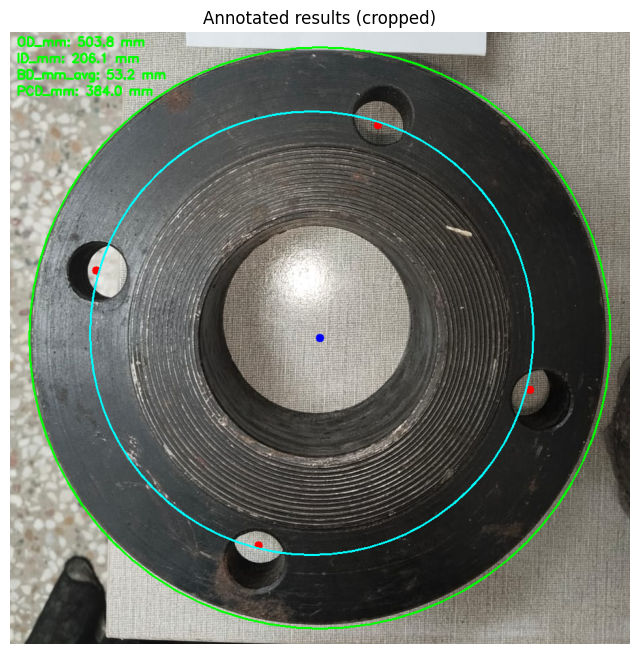

In [ ]:
# -------------------------- Final Results & Visualization --------------------------
print("\n===== FINAL MEASUREMENTS (after calibration if applied) =====")
for k,v in predicted.items():
    print(f" {k}: {v if v is None else f'{v:.2f} mm'}")

# Annotate crop
annot = cropped_bgr.copy()
# draw bolt centers
for c in bolt_centers:
    cv2.circle(annot, (int(c[0]), int(c[1])), 6, (0,0,255), -1)
# draw fitted PCD circle if possible
if len(bolt_centers) >= 3:
    # reuse algebraic fit solved earlier (cx_fit,cy_fit,r_px). If not defined, compute again:
    try:
        pts = np.array(bolt_centers, dtype=np.float64)
        A = np.column_stack([2*pts[:,0], 2*pts[:,1], np.ones(len(pts))])
        b = pts[:,0]**2 + pts[:,1]**2
        sol, *_ = np.linalg.lstsq(A, b, rcond=None)
        cx_fit, cy_fit, c = sol
        r_px = math.sqrt(cx_fit**2 + cy_fit**2 + c)
        cv2.circle(annot, (int(cx_fit), int(cy_fit)), int(round(r_px)), (255,255,0), 2)
    except Exception:
        pass

# draw outer/inner
if outer_center:
    cv2.circle(annot, (int(outer_center[0]), int(outer_center[1])), 6, (255,0,0), -1)
if outer_px_diameter:
    # approximate
    cv2.circle(annot, (int(outer_center[0]), int(outer_center[1])), int(round(outer_px_diameter/2)), (0,255,0), 2)
if inner_px_diameter:
    try:
        icx, icy = inner_center_abs
        cv2.circle(annot, (int(icx), int(icy)), int(round(inner_px_diameter/2)), (0,128,255), 2)
    except:
        pass

# overlay text
y0 = 20
for k,v in predicted.items():
    txt = f"{k}: {v:.1f} mm" if v is not None else f"{k}: N/A"
    cv2.putText(annot, txt, (10,y0), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    y0 += 24

imshow_rgb(bgr_to_rgb(annot), title="Annotated results (cropped)")